##Overview

This notebook implements the last stage of the YouTube recommendation system.\
The candidates from stage 1 are given a new score for each user instance based on additional item data.\

###Model
The model is very similar to the candidates model.\
The user representation is a concatenation of:
1. Averaging over the embeddings of previously watched movies
2. The embedding of the candidate being considered
3. The release year of the movie, normalized by quantiles + powers
4. The movie generes classification (binary per genre)
5. The average rating of the candidate in the database

The concatenation is passed through an MLP with a final single logit output per sample.

###Training
The model is trained with a binary cross entropy, where a positive label is a movie that was watched by the user.\
**NOTE** - the candidates retrieval model is allowed to return previously watched movies. This means that each input may train on more than one positive feedback. Although this may hurt performance on the evaluation of a single target, this complies better to the YouTube model.\
At this stage, the emphasis is on testing impression data and optimization is done on the expected watch time.\
During training, the loss is weighted using the user rating of the sampe. This is somewhat analogous to the watch time in the original paper. Using such weights, the loss is formalized to learn the expected rating, instead of strictly the log-odds.

###Evaluation
The validation and test dataloaders are built such that each batch is comprosed of the target item and all suggested candidates. Notice that the candidates may already contain the target item.\
Our evaluation tries to rank the target item within the scores of all candidates. Doing this from within the candidates completes the recommendation by the full model candidates + ranking.\
We compute HR@5&10, as well as MRR and NDCG.\
In order to evaluate the ranking model by its own, we also test scores that introduce the original target item, even if it was not icluded in the candidates. This answers the question: if the candidate model improved and included the target, how would it rank?

###Hyperparameters
We performed hyperparameter search, evaluated on the validation set. Evaluation was done every 5 epochs for acceleration. We plot below the effect of the MLP size on the results.

###Experiments
We plot the best model training history and evaluate on the test set.\
We present the evaluation metrics at k=5 and k=10.

### Comparison to MF baseline

**Imports and administration**

In [1]:
# basic
# import os 
# import sys
from time import time
import zipfile
import requests
import pickle
import gdown
!pip install --upgrade --no-cache-dir gdown

# general
import warnings
import numpy as np
import pandas as pd

# visual
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# notebook
from IPython.display import display, HTML
from tqdm import tqdm
import copy

# torch
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential
from torch.nn import Sigmoid,ReLU
from torch.nn import Embedding,Linear,Dropout
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor,Compose
from torch.optim import SparseAdam,Adam,Adagrad,SGD

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


**Loading the train, validation and test datasets**

In [ ]:
# path = './drive/My Drive/Colab Notebooks/recsys_final_project/val_train_ranking_5'
# with open(path , 'rb') as f:
#   (val_ranking, train_ranking) = pickle.load(f)
#   print('loaded training and validation')

loaded training and validation


In [2]:
url = "https://drive.google.com/file/d/1DgBiv7tlzRZ4B8j6nUqq2Pl6BYVDq3PU/view?usp=sharing"
ranking_data_train_val_path = 'ranking_data_train_val'
gdown.download(url, ranking_data_train_val_path, quiet=False,fuzzy=True)

# path = './drive/My Drive/Colab Notebooks/recsys_final_project/val_train_ranking_5'
with open(ranking_data_train_val_path , 'rb') as f:
  (val_ranking, train_ranking) = pickle.load(f)
  print('loaded training and validation')


Downloading...
From: https://drive.google.com/uc?id=1DgBiv7tlzRZ4B8j6nUqq2Pl6BYVDq3PU
To: /content/ranking_data_train_val
100%|██████████| 772M/772M [00:08<00:00, 93.0MB/s]


loaded training and validation


In [ ]:
# path = './drive/My Drive/Colab Notebooks/recsys_final_project/test_ranking_5'
# with open(path , 'rb') as f:
#   test_ranking = pickle.load(f)
#   print('loaded test set')

loaded test set


In [5]:
url = "https://drive.google.com/file/d/1iyDanrBCekLnbNsTJNiN5jAR1OKVMJd8/view?usp=sharing"
ranking_data_test_path = 'ranking_data_test'
gdown.download(url, ranking_data_test_path, quiet=False,fuzzy=True)

# path = './drive/My Drive/Colab Notebooks/recsys_final_project/test_ranking_5'
with open(ranking_data_test_path , 'rb') as f:
  test_ranking = pickle.load(f)
  print('loaded test set')

Downloading...
From: https://drive.google.com/uc?id=1iyDanrBCekLnbNsTJNiN5jAR1OKVMJd8
To: /content/ranking_data_test
100%|██████████| 386M/386M [00:01<00:00, 215MB/s]


loaded test set


In [ ]:
# n_candidates = 50
n_candidates = 100

In [ ]:
class Ranking(torch.nn.Module):
    def __init__(self, config):
        super(Ranking, self).__init__()

        self.num_items = config['num_items']
        self.max_watches = config['max_watches']
        self.latent_dim = config['latent_dim']
        self.features_dim = config['features_dim']
        self.layers = config['layers']
        self.embed_items = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim)

        self.fc_layers = torch.nn.ModuleList()
        self.fc_layers.append(torch.nn.Linear(self.features_dim, self.layers[0])) #linking features to MLP
        for (in_size, out_size) in zip(config['layers'][:-1], config['layers'][1:]):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))

        self.mlp_to_logit = torch.nn.Linear(self.layers[-1], 1) #final MLP to predict scalar time without RELU

    def forward(self, features, mode):
        # previous watches embedding and averaging
        n = self.max_watches
        previous_watches = features[:, :n].int()
        mask = torch.unsqueeze((previous_watches > 0),2)
        embedded_items = self.embed_items(previous_watches)
        sum = mask.sum(dim=1)
        sum[sum == 0] = 1 #so we don't divide by 0 and get nan (even though overwritten)
        embedded_items_mean = (embedded_items*mask).sum(dim=1)/sum
        n_indices = torch.count_nonzero(previous_watches, dim=1)
        embedded_items_mean[(n_indices == 0)] = torch.zeros(self.latent_dim).to(device)

        # other embeddings
        candidate_emb = self.embed_items(features[:, n].int()) #embedding of candidate item        
        # other features
        other_features = features[:, n+1:-2]
        # all
        vector = torch.hstack((embedded_items_mean, candidate_emb, other_features)).to(torch.float32)

        for idx, _ in enumerate(range(len(self.fc_layers))):
            vector = self.fc_layers[idx](vector)
            vector = torch.nn.ReLU()(vector)
            #batchnorm and stuff may be added

        vector = self.mlp_to_logit(vector)
        if mode == 'training':
          return vector.squeeze()
        elif mode == 'serving':
          return torch.exp(vector.squeeze())

In [ ]:
class Training(object):

  def __init__(self, model, config):
    self.config = config
    self.model = model.to(self.config['device'])
    self.optimizer = config['optimizer_type'](model.parameters(), **config['optimizer_parameter'])
    self.criterion = config['criterion'](reduction = 'none')
    self.dl_train = DataLoader(val_ranking, batch_size=config['batch_size'], shuffle=True) # create dataloader with given batch size
    self.dl_val = DataLoader(val_ranking, batch_size=config['batch_size'], shuffle=False) # create dataloader with given batch size

  def train(self):
    self.train_loss_history = []
    self.eval_loss_history = []
    self.eval_HR5_history = []
    self.eval_HR10_history = []
    self.eval_HR10_with_target_history = []
    self.eval_MRR5_history = []
    self.eval_NDCG5_history = []
    self.eval_MRR10_history = []
    self.eval_NDCG10_history = []

    epochs_without_improvement = 0
    best_HR = None 
    train_start = time()
    for epoch in range(self.config['n_epochs']):
      self.train_epoch() #train
      self.train_loss_history.append(self.epoch_train_loss/len(self.dl_train))
      # if epoch%5 == 0:
      if epoch%1 == 0:
        self.evaluate_epoch(self.dl_val) #evaluate
        # aggregate metrics
        self.eval_loss_history.append(self.epoch_eval_loss/len(self.dl_val))
        self.eval_HR5_history.append(self.epoch_HR5/len(self.dl_val))
        self.eval_HR10_history.append(self.epoch_HR10/len(self.dl_val))
        self.eval_HR10_with_target_history.append(self.epoch_HR10_with_target/len(self.dl_val))
        self.eval_MRR5_history.append(self.epoch_MRR5/len(self.dl_val))
        self.eval_NDCG5_history.append(self.epoch_NDCG5/len(self.dl_val))
        self.eval_MRR10_history.append(self.epoch_MRR10/len(self.dl_val))
        self.eval_NDCG10_history.append(self.epoch_NDCG10/len(self.dl_val))
        print(f'epoch {epoch}: loss = {self.train_loss_history[-1]}, HR@10with_target = {self.eval_HR10_with_target_history[-1]}, HR@10 = {self.eval_HR10_history[-1]}')
        #check for early stopping
        if not best_HR or self.eval_HR10_history[-1] > best_HR:
          best_HR = self.eval_HR10_history[-1]
          # best_MRR10 = self.eval_MRR10_history[-1]
          # best_NDCG10 = self.eval_NDCG10_history[-1]
          # best_loss = self.eval_loss_history[-1]
          epochs_without_improvement = 0
          #print ("Achieved lower validation loss, save model at epoch number {} ".format(epoch + 1) )
          best_model = copy.deepcopy(self.model.state_dict())
        else:
          epochs_without_improvement += 1

        if epochs_without_improvement == self.config['early_stopping']:
          if self.config['verbose']:
              print('\nEarly stoping after {} epochs. validation loss did not imporve for more than {} epcochs'.format(epoch, self.config['early_stopping']))
          break
    self.training_time = time() - train_start

    # load best model and best performance
    self.model.load_state_dict(best_model)
    if self.config['verbose']:
        print('\nFinished Training:')
        print('Best metrics are:')
        print(f'Hit Ratio eval = {best_HR}')
        # print(f'MRR@10 eval= {best_MRR10}')
        # print(f'NDCG@10 eval= {best_NDCG10}')
    
  def train_epoch(self):
    self.epoch_train_loss   = 0
    self.model.train() # train mode
    for batch in tqdm(self.dl_train, disable=(not self.config['verbose'])):
      self.train_batch(batch)

  def train_batch(self, batch):
    batch = batch.to(device)  
    pred = self.model(batch, mode = 'training')
    labels = batch[:,-1]
    batch_weights = batch[:,-2]
    #weighting loss by rating (normalized rating)
    loss = self.criterion(pred, labels)
    loss = loss * batch_weights
    loss = torch.mean(loss)
              
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()               
    self.epoch_train_loss += loss.item()

  def evaluate_epoch(self, dl_eval):
    self.epoch_eval_loss = 0
    self.epoch_HR5 = 0
    self.epoch_HR10 = 0
    self.epoch_HR10_with_target = 0
    self.epoch_MRR5 = 0
    self.epoch_NDCG5 = 0
    self.epoch_MRR10 = 0
    self.epoch_NDCG10 = 0

    self.model.eval() #evaluation mode
    with torch.no_grad():
      for batch in tqdm(dl_eval, disable=(not self.config['verbose'])):
        self.eval_batch(batch) # dl_val was built so that one batch is one user


  def eval_batch(self, batch):
    # Send tensor to GPU    
    batch = batch.to(device)
    expected_time = self.model(batch, mode = 'serving')
    target_time = expected_time[-1] # This is our original target rating
    candidates_times, ind = torch.sort(-(expected_time[:-1])) #indices to sort pred, descending
    candidates_times_with_target, ind = torch.sort(-expected_time) #indices to sort pred, descending

    self.epoch_HR5 += self.HitRatio(candidates_times, -target_time, 5)
    self.epoch_HR10 += self.HitRatio(candidates_times, -target_time, 10)
    self.epoch_HR10_with_target += self.HitRatio(candidates_times_with_target, -target_time, 10)
    self.epoch_MRR5 += self.MRR(candidates_times, -target_time, 5)
    self.epoch_MRR10 += self.MRR(candidates_times, -target_time, 10)
    self.epoch_NDCG5 += self.NDCG(candidates_times, -target_time, 5)
    self.epoch_NDCG10 += self.NDCG(candidates_times, -target_time, 10)

  def HitRatio(self, ranked_items, target_item, k):
    for item in ranked_items[:k]:
      if item == target_item:
        return 1
    return 0

  def MRR(self, ranked_items, target_item, k):
    for i, item in enumerate(ranked_items[:k]):
      if item == target_item:
        return 1/(i + 1)
    return 0


  def NDCG(self, ranked_items, target_item, k):
    for i, item in enumerate(ranked_items[:k]):
      if item == target_item:
        return np.log(2)/np.log(i + 2)
    return 0


###hyperparameters search
We show optimization for MLP dimensions, as in the paper, after learning rate was optimized as well.\
evaluation was done every 5 epochs.\
We recorded only HR@10 with and without target item and training time.

**NOTE - hyperparameters search takes a long time. My results can be downloaded below**

In [ ]:
# results = pd.DataFrame(columns=['maximal width', 'Batch Size', 'Learning Rate', 'Topk', 'Metric', 'Score']) #uncomment to run

In [ ]:
# path = './drive/My Drive/Colab Notebooks/recsys_final_ranking_by_layers'
# with open(path , 'rb') as f:
#   (results) = pickle.load(f)
#   print('loaded training')

In [ ]:
def add_results(training_model, results_df, max_width, batch_size, lr):

  hr10 = training_model.epoch_HR10/len(training_model.dl_val)
  hr10_with_target = training_model.epoch_HR10_with_target/len(training_model.dl_val)
  tr_time = training_model.training_time

  results_df.loc[len(results_df)] = max_width, batch_size, lr, 0, 'TIME', tr_time
  results_df.loc[len(results_df)] = max_width, batch_size, lr, 10, 'HR', hr10
  results_df.loc[len(results_df)] = max_width, batch_size, lr, 10, 'HR_with_target', hr10_with_target

In [ ]:
batch_size = n_candidates + 1
lr = 0.001
layers_list = [[256], [512, 256], [1024, 512, 256], [2048, 1024, 512, 256]]

for layers in layers_list:
  torch.manual_seed(42)
  np.random.seed(42) 
  max_width = layers[0]
  ranking_config = {'num_items': 3953, 'max_watches': 50, 'latent_dim': 256, 'features_dim': 534, 'layers':layers}
  model_ranking = Ranking(ranking_config)

  training_config = {'batch_size': batch_size, 'optimizer_type': Adam, 'optimizer_parameter': {'lr': lr}, \
                  'criterion' : torch.nn.BCEWithLogitsLoss, 'n_epochs' : 51, 'early_stopping' : 8, 'verbose' : True, 'device' : device}

  training_ranking = Training(model_ranking, training_config)
  training_ranking.train()
  training_ranking.evaluate_epoch(training_ranking.dl_val)
  add_results(training_ranking, results, max_width, batch_size, lr)

100%|██████████| 6040/6040 [00:14<00:00, 409.82it/s]


epoch 0: loss = 1.088795038367672, HR@10with_target = 0.11009933774834436, HR@10 = 0.046688741721854304


100%|██████████| 6040/6040 [00:13<00:00, 434.43it/s]


epoch 5: loss = 0.7571669886446488, HR@10with_target = 0.23278145695364238, HR@10 = 0.06788079470198675


100%|██████████| 6040/6040 [00:13<00:00, 441.24it/s]


epoch 10: loss = 0.5874368631038162, HR@10with_target = 0.30960264900662254, HR@10 = 0.08079470198675497


100%|██████████| 6040/6040 [00:13<00:00, 436.00it/s]


epoch 15: loss = 0.46031758708396414, HR@10with_target = 0.3536423841059603, HR@10 = 0.09221854304635761


100%|██████████| 6040/6040 [00:13<00:00, 439.82it/s]


epoch 20: loss = 0.3606383133471325, HR@10with_target = 0.3887417218543046, HR@10 = 0.09387417218543047


100%|██████████| 6040/6040 [00:14<00:00, 407.83it/s]


epoch 25: loss = 0.2820814274931556, HR@10with_target = 0.398841059602649, HR@10 = 0.09519867549668874


100%|██████████| 6040/6040 [00:17<00:00, 347.84it/s]


epoch 30: loss = 0.21986395601400655, HR@10with_target = 0.42102649006622517, HR@10 = 0.10099337748344371


100%|██████████| 6040/6040 [00:18<00:00, 333.64it/s]


epoch 35: loss = 0.17520290608638492, HR@10with_target = 0.4375827814569536, HR@10 = 0.10662251655629139


100%|██████████| 6040/6040 [00:18<00:00, 334.09it/s]


epoch 40: loss = 0.13800090654113967, HR@10with_target = 0.45, HR@10 = 0.10364238410596026


100%|██████████| 6040/6040 [00:17<00:00, 341.78it/s]


epoch 45: loss = 0.11387094698595857, HR@10with_target = 0.44304635761589406, HR@10 = 0.10182119205298014


100%|██████████| 6040/6040 [00:17<00:00, 338.54it/s]


epoch 50: loss = 0.09645466886344652, HR@10with_target = 0.46258278145695364, HR@10 = 0.10513245033112582

Finished Training:
Best metrics are:
Hit Ratio eval = 0.10662251655629139


100%|██████████| 6040/6040 [00:19<00:00, 304.56it/s]


epoch 0: loss = 1.0940786187497233, HR@10with_target = 0.07582781456953643, HR@10 = 0.041225165562913904


100%|██████████| 6040/6040 [00:19<00:00, 310.90it/s]


epoch 5: loss = 0.7408595222756297, HR@10with_target = 0.23774834437086093, HR@10 = 0.06986754966887417


100%|██████████| 6040/6040 [00:19<00:00, 316.91it/s]


epoch 10: loss = 0.549247750663613, HR@10with_target = 0.3456953642384106, HR@10 = 0.09155629139072848


100%|██████████| 6040/6040 [00:18<00:00, 326.57it/s]


epoch 15: loss = 0.41582991896192395, HR@10with_target = 0.40827814569536425, HR@10 = 0.10016556291390728


100%|██████████| 6040/6040 [00:14<00:00, 419.87it/s]


epoch 20: loss = 0.31758101551867174, HR@10with_target = 0.46357615894039733, HR@10 = 0.10910596026490066


100%|██████████| 6040/6040 [00:14<00:00, 416.17it/s]


epoch 25: loss = 0.24568128697807806, HR@10with_target = 0.46357615894039733, HR@10 = 0.11274834437086093


100%|██████████| 6040/6040 [00:14<00:00, 419.00it/s]


epoch 30: loss = 0.1927231316971708, HR@10with_target = 0.49387417218543045, HR@10 = 0.12367549668874173


100%|██████████| 6040/6040 [00:14<00:00, 419.76it/s]


epoch 35: loss = 0.15418862322071006, HR@10with_target = 0.47003311258278146, HR@10 = 0.11788079470198676


100%|██████████| 6040/6040 [00:14<00:00, 416.60it/s]


epoch 40: loss = 0.12742253584433, HR@10with_target = 0.4600993377483444, HR@10 = 0.11076158940397351


100%|██████████| 6040/6040 [00:14<00:00, 404.91it/s]


epoch 45: loss = 0.10657929578587384, HR@10with_target = 0.46192052980132453, HR@10 = 0.11225165562913907


100%|██████████| 6040/6040 [00:14<00:00, 424.61it/s]


epoch 50: loss = 0.09242220713487835, HR@10with_target = 0.45794701986754965, HR@10 = 0.11374172185430463

Finished Training:
Best metrics are:
Hit Ratio eval = 0.12367549668874173


100%|██████████| 6040/6040 [00:15<00:00, 397.74it/s]


epoch 0: loss = 1.0978964480244051, HR@10with_target = 0.08311258278145696, HR@10 = 0.038741721854304634


100%|██████████| 6040/6040 [00:15<00:00, 395.68it/s]


epoch 5: loss = 0.7264048896543078, HR@10with_target = 0.2316225165562914, HR@10 = 0.06837748344370861


100%|██████████| 6040/6040 [00:14<00:00, 403.79it/s]


epoch 10: loss = 0.5273249165557042, HR@10with_target = 0.37350993377483444, HR@10 = 0.09271523178807947


100%|██████████| 6040/6040 [00:15<00:00, 391.06it/s]


epoch 15: loss = 0.3912064177351309, HR@10with_target = 0.45264900662251656, HR@10 = 0.10910596026490066


100%|██████████| 6040/6040 [00:15<00:00, 394.61it/s]


epoch 20: loss = 0.2909012402093499, HR@10with_target = 0.46125827814569537, HR@10 = 0.11357615894039735


100%|██████████| 6040/6040 [00:15<00:00, 390.12it/s]


epoch 25: loss = 0.21664529860121712, HR@10with_target = 0.4552980132450331, HR@10 = 0.11158940397350993


100%|██████████| 6040/6040 [00:15<00:00, 402.58it/s]


epoch 30: loss = 0.16455641414581335, HR@10with_target = 0.43559602649006623, HR@10 = 0.11821192052980133


100%|██████████| 6040/6040 [00:15<00:00, 399.93it/s]


epoch 35: loss = 0.12675607167170871, HR@10with_target = 0.42450331125827817, HR@10 = 0.11556291390728476


100%|██████████| 6040/6040 [00:15<00:00, 383.02it/s]


epoch 40: loss = 0.10179412008647437, HR@10with_target = 0.4120860927152318, HR@10 = 0.1185430463576159


100%|██████████| 6040/6040 [00:15<00:00, 393.42it/s]


epoch 45: loss = 0.08460325384395707, HR@10with_target = 0.3923841059602649, HR@10 = 0.11556291390728476


100%|██████████| 6040/6040 [00:14<00:00, 403.27it/s]


epoch 50: loss = 0.07314226906080792, HR@10with_target = 0.37996688741721857, HR@10 = 0.11556291390728476

Finished Training:
Best metrics are:
Hit Ratio eval = 0.1185430463576159


100%|██████████| 6040/6040 [00:15<00:00, 384.19it/s]


epoch 0: loss = 1.1012152789794394, HR@10with_target = 0.07996688741721854, HR@10 = 0.0423841059602649


100%|██████████| 6040/6040 [00:15<00:00, 383.18it/s]


epoch 5: loss = 0.7172707318640856, HR@10with_target = 0.23874172185430464, HR@10 = 0.07201986754966887


100%|██████████| 6040/6040 [00:15<00:00, 395.58it/s]


epoch 10: loss = 0.5121580674786882, HR@10with_target = 0.36324503311258277, HR@10 = 0.08874172185430464


100%|██████████| 6040/6040 [00:15<00:00, 397.97it/s]


epoch 15: loss = 0.3727389885891666, HR@10with_target = 0.47516556291390727, HR@10 = 0.10860927152317881


100%|██████████| 6040/6040 [00:14<00:00, 403.38it/s]


epoch 20: loss = 0.273179836660493, HR@10with_target = 0.4687086092715232, HR@10 = 0.10960264900662252


100%|██████████| 6040/6040 [00:14<00:00, 406.92it/s]


epoch 25: loss = 0.20432486885561424, HR@10with_target = 0.45248344370860927, HR@10 = 0.1162251655629139


100%|██████████| 6040/6040 [00:15<00:00, 388.43it/s]


epoch 30: loss = 0.15728935474920963, HR@10with_target = 0.4644039735099338, HR@10 = 0.11357615894039735


100%|██████████| 6040/6040 [00:15<00:00, 400.67it/s]


epoch 35: loss = 0.12694815658108538, HR@10with_target = 0.45049668874172183, HR@10 = 0.11672185430463576


100%|██████████| 6040/6040 [00:14<00:00, 404.49it/s]


epoch 40: loss = 0.10501115748445805, HR@10with_target = 0.3912251655629139, HR@10 = 0.11009933774834436


100%|██████████| 6040/6040 [00:15<00:00, 391.84it/s]


epoch 45: loss = 0.09580192040343626, HR@10with_target = 0.3935430463576159, HR@10 = 0.11341059602649006


100%|██████████| 6040/6040 [00:14<00:00, 410.16it/s]


epoch 50: loss = 0.07979786529207127, HR@10with_target = 0.38658940397350994, HR@10 = 0.11440397350993377

Finished Training:
Best metrics are:
Hit Ratio eval = 0.11672185430463576


100%|██████████| 6040/6040 [00:14<00:00, 404.40it/s]


In [ ]:
results

,maximal width,Batch Size,Learning Rate,Topk,Metric,Score
0,256,101,0.001,0,TIME,1587.149347
1,256,101,0.001,10,HR,0.106623
2,256,101,0.001,10,HR_with_target,0.437583
3,512,101,0.001,0,TIME,1750.902994
4,512,101,0.001,10,HR,0.123675
5,512,101,0.001,10,HR_with_target,0.493874
6,1024,101,0.001,0,TIME,1705.056161
7,1024,101,0.001,10,HR,0.118543
8,1024,101,0.001,10,HR_with_target,0.412086
9,2048,101,0.001,0,TIME,2051.424432


In [ ]:
# path = './drive/My Drive/Colab Notebooks/recsys_final_ranking_by_layers'
# with open(path, 'wb') as f:
#   pickle.dump((results), f)

In [ ]:
# path = './drive/My Drive/Colab Notebooks/recsys_final_ranking_by_layers'
# with open(path , 'rb') as f:
#   (results) = pickle.load(f)
#   # print('loaded results')

In [7]:
url = "https://drive.google.com/file/d/1yjFe6EgK1o-q79yRu-mjUElUtygdH6Au/view?usp=sharing"
hyper_results_path = 'hyper_results'
gdown.download(url, hyper_results_path, quiet=False,fuzzy=True)

# path = './drive/My Drive/Colab Notebooks/recsys_final_ranking_by_layers'
with open(hyper_results_path , 'rb') as f:
  (results) = pickle.load(f)
  # print('loaded results')

Downloading...
From: https://drive.google.com/uc?id=1yjFe6EgK1o-q79yRu-mjUElUtygdH6Au
To: /content/hyper_results
100%|██████████| 1.51k/1.51k [00:00<00:00, 4.41MB/s]


Text(0.5, 1.0, 'HR@10 vs MLP size with added target')

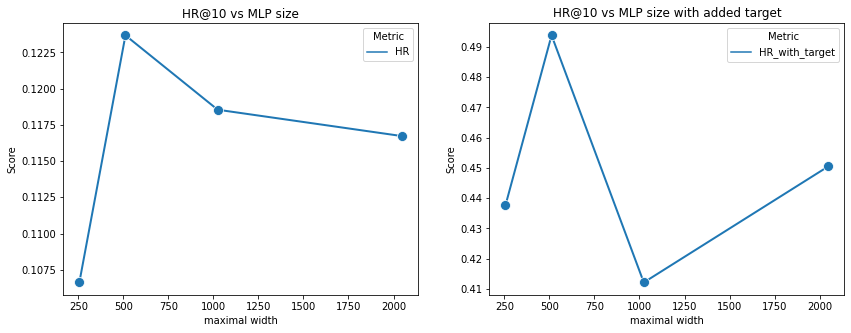

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
HR_results = results[(results['Metric'] == 'HR')]
HR_results_with_target = results[(results['Metric'] == 'HR_with_target')]
r = sns.lineplot(data = HR_results, x = 'maximal width', y = 'Score', hue = 'Metric', ax = ax1, marker="o", linewidth = 2, markersize=10)
ax1.set_title('HR@10 vs MLP size')
r = sns.lineplot(data = HR_results_with_target, x = 'maximal width', y = 'Score', hue = 'Metric', ax = ax2, marker="o", linewidth = 2, markersize=10)
ax2.set_title('HR@10 vs MLP size with added target')

###Best performance model
As we can see, the two layers model is found to give the best results: 512->256\
We then run a model with continuous evaluation and finally, evaluate it on the test set.

In [ ]:
best_results = pd.DataFrame(columns=['maximal width', 'Batch Size', 'Learning Rate', 'Topk', 'Metric', 'Score']) #uncomment to run

In [ ]:
def add_results_all(training_model, results_df, max_width, batch_size, lr):

  # loss = training_model.epoch_eval_loss/len(training_model.dl_val)
  hr5 = training_model.epoch_HR5/len(training_model.dl_val)
  hr10 = training_model.epoch_HR10/len(training_model.dl_val)
  mrr5 = training_model.epoch_MRR5/len(training_model.dl_val)
  mrr10 = training_model.epoch_MRR10/len(training_model.dl_val)
  ndcg5 = training_model.epoch_NDCG5/len(training_model.dl_val)
  ndcg10 = training_model.epoch_NDCG10/len(training_model.dl_val)
  tr_time = training_model.training_time

  # results_df.loc[len(results_df)] = max_width, batch_size, lr, 0, 'LOSS', loss
  results_df.loc[len(results_df)] = max_width, batch_size, lr, 0, 'TIME', tr_time
  results_df.loc[len(results_df)] = max_width, batch_size, lr, 5, 'HR' , hr5
  results_df.loc[len(results_df)] = max_width, batch_size, lr, 10, 'HR', hr10
  results_df.loc[len(results_df)] = max_width, batch_size, lr, 5, 'MRR', mrr5
  results_df.loc[len(results_df)] = max_width, batch_size, lr, 10, 'MRR', mrr10
  results_df.loc[len(results_df)] = max_width, batch_size, lr, 5, 'NDCG', ndcg5
  results_df.loc[len(results_df)] = max_width, batch_size, lr, 10, 'NDCG', ndcg10

In [ ]:
torch.manual_seed(42)
np.random.seed(42)
max_width = 512
batch_size = n_candidates + 1
dl_test = DataLoader(test_ranking, batch_size=batch_size, shuffle=False)
lr = 0.001
ranking_config = {'num_items': 3953, 'max_watches': 50, 'latent_dim': 256, 'features_dim': 534, 'layers':[512, 256]}
model_ranking = Ranking(ranking_config)

training_config = {'batch_size': batch_size, 'optimizer_type': Adam, 'optimizer_parameter': {'lr': lr}, \
                'criterion' : torch.nn.BCEWithLogitsLoss, 'n_epochs' : 61, 'early_stopping' : 8, 'verbose' : True, 'device' : device}

training_ranking = Training(model_ranking, training_config)
training_ranking.train()
training_ranking.evaluate_epoch(dl_test)
add_results_all(training_ranking, best_results, max_width, batch_size, lr)

100%|██████████| 6040/6040 [00:20<00:00, 296.93it/s]


epoch 0: loss = 1.0940786187497233, HR@10with_target = 0.07582781456953643, HR@10 = 0.041225165562913904


100%|██████████| 6040/6040 [00:20<00:00, 296.28it/s]


epoch 1: loss = 0.9716102779179069, HR@10with_target = 0.11804635761589403, HR@10 = 0.04718543046357616


100%|██████████| 6040/6040 [00:20<00:00, 294.42it/s]


epoch 2: loss = 0.9007196526093846, HR@10with_target = 0.15033112582781458, HR@10 = 0.054304635761589407


100%|██████████| 6040/6040 [00:20<00:00, 296.00it/s]


epoch 3: loss = 0.8420651047282337, HR@10with_target = 0.18162251655629139, HR@10 = 0.06158940397350993


100%|██████████| 6040/6040 [00:19<00:00, 308.45it/s]


epoch 4: loss = 0.7888030659482708, HR@10with_target = 0.22367549668874173, HR@10 = 0.06771523178807946


100%|██████████| 6040/6040 [00:20<00:00, 295.53it/s]


epoch 5: loss = 0.7411376302133588, HR@10with_target = 0.2504966887417219, HR@10 = 0.06804635761589405


100%|██████████| 6040/6040 [00:19<00:00, 305.31it/s]


epoch 6: loss = 0.6967342535409216, HR@10with_target = 0.26688741721854303, HR@10 = 0.076158940397351


100%|██████████| 6040/6040 [00:20<00:00, 299.02it/s]


epoch 7: loss = 0.6562959303887272, HR@10with_target = 0.2990066225165563, HR@10 = 0.08394039735099337


100%|██████████| 6040/6040 [00:20<00:00, 294.72it/s]


epoch 8: loss = 0.617731650937129, HR@10with_target = 0.33195364238410596, HR@10 = 0.08559602649006623


100%|██████████| 6040/6040 [00:19<00:00, 310.38it/s]


epoch 9: loss = 0.5822911763062049, HR@10with_target = 0.36241721854304637, HR@10 = 0.0978476821192053


100%|██████████| 6040/6040 [00:20<00:00, 297.03it/s]


epoch 10: loss = 0.5489415090972314, HR@10with_target = 0.3653973509933775, HR@10 = 0.09470198675496688


100%|██████████| 6040/6040 [00:19<00:00, 307.31it/s]


epoch 11: loss = 0.5184509465441842, HR@10with_target = 0.35380794701986756, HR@10 = 0.09602649006622517


100%|██████████| 6040/6040 [00:19<00:00, 313.08it/s]


epoch 12: loss = 0.48947572758423524, HR@10with_target = 0.38559602649006625, HR@10 = 0.09635761589403974


100%|██████████| 6040/6040 [00:20<00:00, 297.50it/s]


epoch 13: loss = 0.46347162387534724, HR@10with_target = 0.41456953642384103, HR@10 = 0.10248344370860928


100%|██████████| 6040/6040 [00:19<00:00, 309.53it/s]


epoch 14: loss = 0.43731647420529, HR@10with_target = 0.45264900662251656, HR@10 = 0.10397350993377484


100%|██████████| 6040/6040 [00:19<00:00, 303.72it/s]


epoch 15: loss = 0.41358528568095076, HR@10with_target = 0.4187086092715232, HR@10 = 0.10529801324503311


100%|██████████| 6040/6040 [00:20<00:00, 299.03it/s]


epoch 16: loss = 0.3916555604224604, HR@10with_target = 0.44950331125827814, HR@10 = 0.10827814569536424


100%|██████████| 6040/6040 [00:19<00:00, 312.06it/s]


epoch 17: loss = 0.36997367611953663, HR@10with_target = 0.45612582781456956, HR@10 = 0.11043046357615895


100%|██████████| 6040/6040 [00:20<00:00, 298.09it/s]


epoch 18: loss = 0.35233725312915604, HR@10with_target = 0.43956953642384106, HR@10 = 0.10662251655629139


100%|██████████| 6040/6040 [00:18<00:00, 320.63it/s]


epoch 19: loss = 0.3325200944123003, HR@10with_target = 0.4609271523178808, HR@10 = 0.11142384105960265


100%|██████████| 6040/6040 [00:18<00:00, 318.20it/s]


epoch 20: loss = 0.31530226312017706, HR@10with_target = 0.46473509933774837, HR@10 = 0.11043046357615895


100%|██████████| 6040/6040 [00:20<00:00, 296.24it/s]


epoch 21: loss = 0.2986615421635607, HR@10with_target = 0.4382450331125828, HR@10 = 0.10811258278145695


100%|██████████| 6040/6040 [00:19<00:00, 312.79it/s]


epoch 22: loss = 0.28339979955798494, HR@10with_target = 0.46241721854304635, HR@10 = 0.11274834437086093


100%|██████████| 6040/6040 [00:19<00:00, 311.00it/s]


epoch 23: loss = 0.26905252640781374, HR@10with_target = 0.4730132450331126, HR@10 = 0.11291390728476822


100%|██████████| 6040/6040 [00:19<00:00, 304.65it/s]


epoch 24: loss = 0.2571076417270017, HR@10with_target = 0.4783112582781457, HR@10 = 0.11490066225165563


100%|██████████| 6040/6040 [00:19<00:00, 313.51it/s]


epoch 25: loss = 0.24325569442948686, HR@10with_target = 0.48079470198675495, HR@10 = 0.1140728476821192


100%|██████████| 6040/6040 [00:20<00:00, 299.17it/s]


epoch 26: loss = 0.23184001950590843, HR@10with_target = 0.47897350993377485, HR@10 = 0.11456953642384106


100%|██████████| 6040/6040 [00:19<00:00, 316.82it/s]


epoch 27: loss = 0.2208141180144073, HR@10with_target = 0.4817880794701987, HR@10 = 0.11274834437086093


100%|██████████| 6040/6040 [00:19<00:00, 303.36it/s]


epoch 28: loss = 0.21043507239241566, HR@10with_target = 0.4706953642384106, HR@10 = 0.1119205298013245


100%|██████████| 6040/6040 [00:20<00:00, 297.51it/s]


epoch 29: loss = 0.20055208123351978, HR@10with_target = 0.48526490066225164, HR@10 = 0.11572847682119206


100%|██████████| 6040/6040 [00:19<00:00, 314.56it/s]


epoch 30: loss = 0.19167152422476877, HR@10with_target = 0.477317880794702, HR@10 = 0.11374172185430463


100%|██████████| 6040/6040 [00:19<00:00, 307.36it/s]


epoch 31: loss = 0.18382690446943623, HR@10with_target = 0.47582781456953643, HR@10 = 0.1173841059602649


100%|██████████| 6040/6040 [00:19<00:00, 304.63it/s]


epoch 32: loss = 0.17338686082352112, HR@10with_target = 0.4812913907284768, HR@10 = 0.11357615894039735


100%|██████████| 6040/6040 [00:20<00:00, 300.09it/s]


epoch 33: loss = 0.16773036866789195, HR@10with_target = 0.47665562913907283, HR@10 = 0.11324503311258279


100%|██████████| 6040/6040 [00:20<00:00, 298.63it/s]


epoch 34: loss = 0.1597289624271836, HR@10with_target = 0.47466887417218545, HR@10 = 0.11341059602649006


100%|██████████| 6040/6040 [00:19<00:00, 308.22it/s]


epoch 35: loss = 0.15293920415169013, HR@10with_target = 0.47003311258278146, HR@10 = 0.10877483443708609


100%|██████████| 6040/6040 [00:19<00:00, 315.87it/s]


epoch 36: loss = 0.1463525019308188, HR@10with_target = 0.4731788079470199, HR@10 = 0.11490066225165563


100%|██████████| 6040/6040 [00:20<00:00, 299.55it/s]


epoch 37: loss = 0.13894271505970474, HR@10with_target = 0.4814569536423841, HR@10 = 0.11821192052980133


100%|██████████| 6040/6040 [00:19<00:00, 310.33it/s]


epoch 38: loss = 0.1358695747014847, HR@10with_target = 0.473841059602649, HR@10 = 0.11605960264900662


100%|██████████| 6040/6040 [00:19<00:00, 307.38it/s]


epoch 39: loss = 0.12999942590168823, HR@10with_target = 0.4695364238410596, HR@10 = 0.11605960264900662


100%|██████████| 6040/6040 [00:19<00:00, 309.46it/s]


epoch 40: loss = 0.1260047892342983, HR@10with_target = 0.48311258278145697, HR@10 = 0.11109271523178808


100%|██████████| 6040/6040 [00:19<00:00, 311.17it/s]


epoch 41: loss = 0.12043938140723774, HR@10with_target = 0.45728476821192054, HR@10 = 0.11142384105960265


100%|██████████| 6040/6040 [00:20<00:00, 294.72it/s]


epoch 42: loss = 0.11598286494255759, HR@10with_target = 0.4695364238410596, HR@10 = 0.11589403973509933


100%|██████████| 6040/6040 [00:19<00:00, 309.06it/s]


epoch 43: loss = 0.11238907817886233, HR@10with_target = 0.47566225165562914, HR@10 = 0.11556291390728476


100%|██████████| 6040/6040 [00:19<00:00, 304.82it/s]


epoch 44: loss = 0.10870043281620931, HR@10with_target = 0.4778145695364238, HR@10 = 0.11589403973509933


100%|██████████| 6040/6040 [00:20<00:00, 299.06it/s]


epoch 45: loss = 0.10559341634754671, HR@10with_target = 0.4640728476821192, HR@10 = 0.11092715231788079

Early stoping after 45 epochs. validation loss did not imporve for more than 8 epcochs

Finished Training:
Best metrics are:
Hit Ratio eval = 0.11821192052980133


100%|██████████| 6040/6040 [00:19<00:00, 308.00it/s]


In [ ]:
best_results

,maximal width,Batch Size,Learning Rate,Topk,Metric,Score
0,512,101,0.001,0,LOSS,0.000000
1,512,101,0.001,0,TIME,2123.222918
2,512,101,0.001,5,HR,0.035927
3,512,101,0.001,10,HR,0.097020
4,512,101,0.001,5,MRR,0.014156
5,512,101,0.001,10,MRR,0.021927
6,512,101,0.001,5,NDCG,0.019449
7,512,101,0.001,10,NDCG,0.038822


In [ ]:
# path = './drive/My Drive/Colab Notebooks/recsys_final_ranking_best_results'
# with open(path, 'wb') as f:
#   pickle.dump((best_results), f)

In [ ]:
def plot_training_summary(training_model, title):
  with plt.rc_context({'lines.linewidth': 1.5, 'lines.marker' : '.', 'lines.markersize' : 8}):

    epochs = np.arange(len(training_model.train_loss_history)) + 1
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25,5))
    ax1.plot(epochs, training_model.train_loss_history, 'r', label = 'train loss')
    # ax1.plot(epochs, training_model.eval_loss_history, 'orange', label = 'eval loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('LogLoss')
    ax1.legend()
    ax2.plot(epochs, training_model.eval_HR5_history, 'b', label = 'Hit Ratio@5')
    ax2.plot(epochs, training_model.eval_HR10_history, 'g', label = 'Hit Ratio@10')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Hit Ratio')
    ax2.legend()
    ax3.plot(epochs, training_model.eval_MRR5_history, 'b', label = 'MRR@5')
    ax3.plot(epochs, training_model.eval_MRR10_history, 'g', label = 'MRR@10')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('MRR')
    ax3.legend()
    ax4.plot(epochs, training_model.eval_NDCG5_history, 'b', label = 'NDCG@5')
    ax4.plot(epochs, training_model.eval_NDCG10_history, 'g', label = 'NDCG@10')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('NDCG')
    ax4.legend()
    fig.suptitle(title, fontsize = 16)

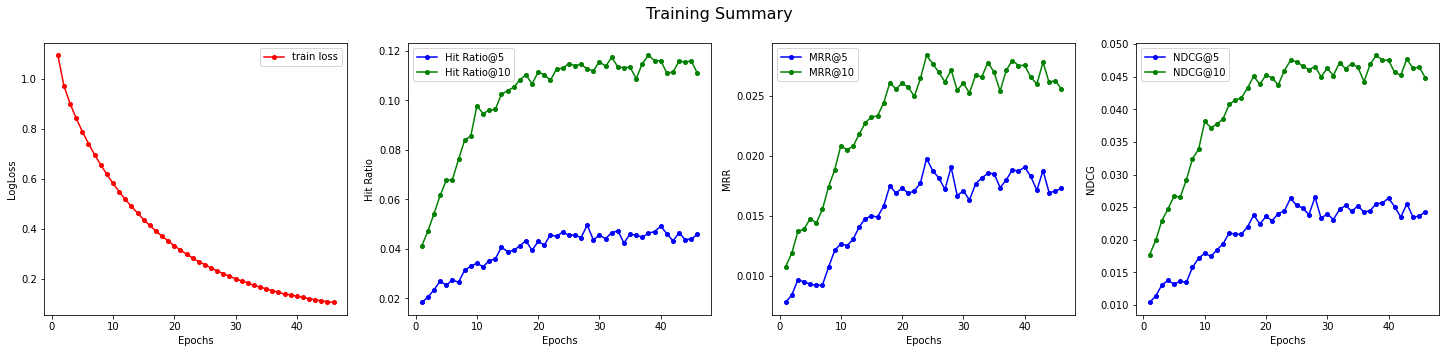

In [ ]:
plot_training_summary(training_ranking, 'Training Summary')

In [ ]:
# The final test HR10 evaluation!
training_ranking.epoch_HR10/len(training_ranking.dl_val)

0.09701986754966888

###Conclusions
1. Evaluation on the test set was 9.7%. This means that the combined candidates and ranking model (start to end) was able to place the target movie within the first 10 places out of 3952 in almost 10% of the cases.
2. If the target item is considered as a candidate, the ranking model is able to place it within the first 10 places in about 49% of the cases.
